<a href="https://colab.research.google.com/github/soumyajit09/dog-breed-identification/blob/master/dog_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to End multiclass dog breed classification

This model builds an end to end multiclass image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem 

Identifying the breed of dog given an image of a dog.

## 2. Data

The Data we're using dfrom kaggle.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

Predicting probabilites for each dog breed of each test image.

## 4. Features

Some information about the data
* We're dealing with images (unstructured data).
* We're going to use Deep Learning and Transfer Learning.
* There are total 120 breeds of dogs (this means 120 different classes).
* There are total 10,000+ images in training set (this images have labels).
* There are total 10,000+ images in test set (This images have no labels becoz we will have to predict them.).


In [0]:
#!unzip "drive/My Drive/p.zip" -d "drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification"

### Getting our workspace ready

* Import TensorFlow (ver-2.x)
* Import TensorFlow Hub
* Make sure you are using a GPU

In [0]:
# Import tensorflow into colab
import tensorflow as tf
print('TF version', tf.__version__)

TF version 2.2.0-rc2


In [0]:
# Import TensorFlow Hub
import tensorflow_hub as hub
print("TF Hub version", hub.__version__)

TF Hub version 0.8.0


In [0]:
# Check for GPU availability
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else "not available")

GPU Available


In [0]:
# Use the code only if u want to use tpu
# import tensorflow as tf
# import os
# import tensorflow_datasets as tfds
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [0]:
# Importing the tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Getting our data ready (turning it to tensors)

In [0]:
labels_csv = pd.read_csv("drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/labels.csv")
labels_csv

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [0]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     666eeaec16b885a3b9c11b9a9c5e8cbf  scottish_deerhound
freq                                   1                 126

In [0]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [0]:
# How many images in each breed 
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
golden_retriever         67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

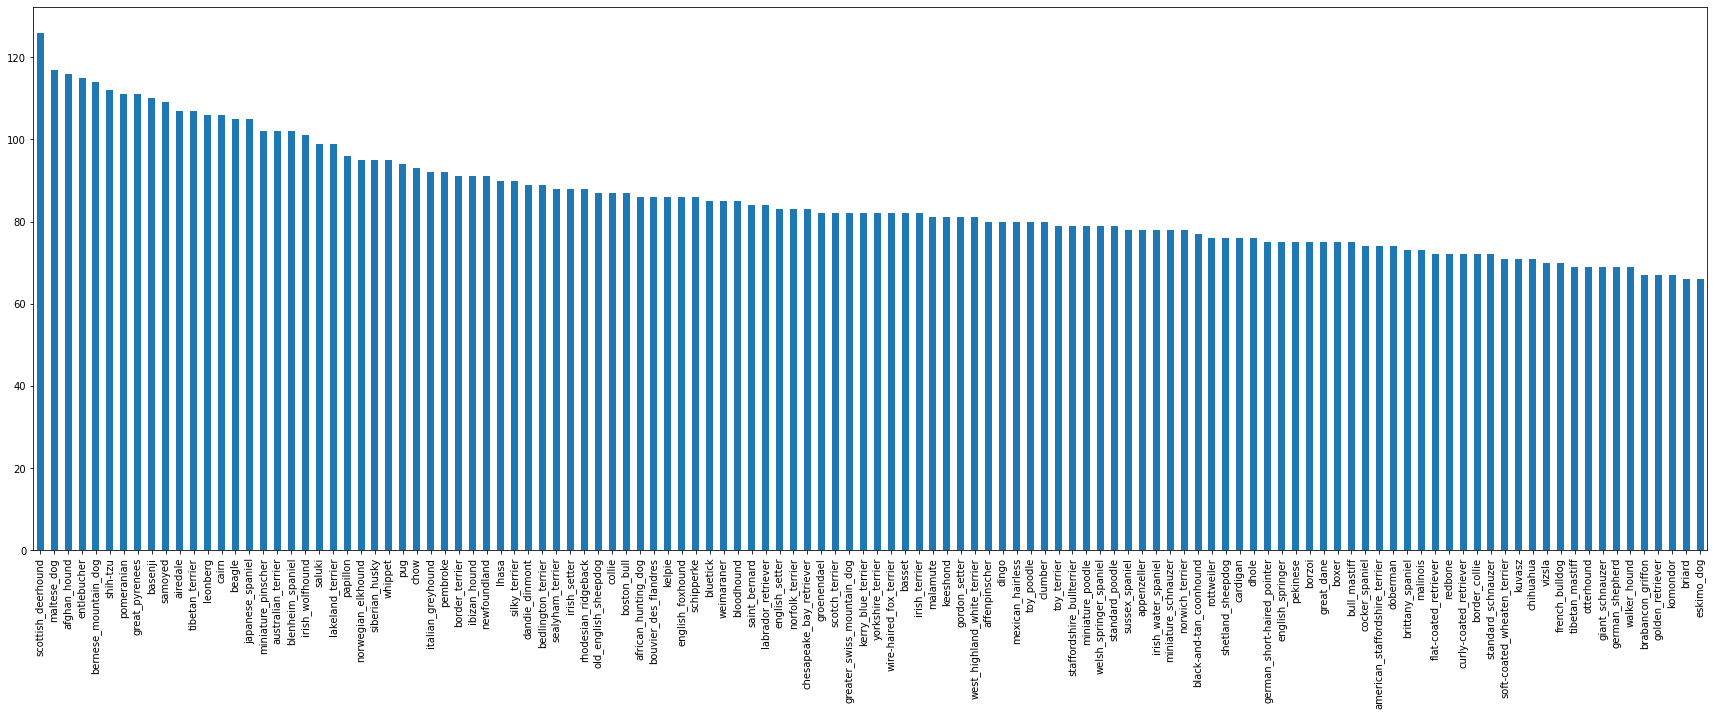

In [0]:
# Let's visualize the above data
labels_csv["breed"].value_counts().plot(kind="bar", figsize=(30,10))

In [0]:
# Adding a median value
labels_csv["breed"].value_counts().median()

82.0

## Preparing the images

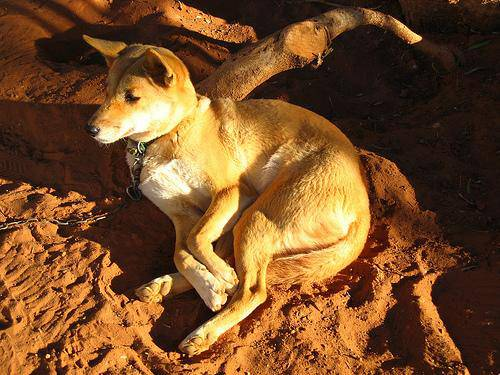

In [0]:
from IPython.display import Image
Image("drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Getting images and their labels

let's get a list of all our image file path names

In [0]:
# create path names from image id's
filenames = ["drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/"+fname+".jpg" for fname in labels_csv['id']]

# Check the output
filenames[:10]

['drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Colab Notebooks/dog-ide

In [0]:
# Check whether number of filenames matches with number of actual image files
import os
if len(os.listdir("drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/"))==len(filenames):
  print("Filenames match actual amount of files")
else:
  print("Filenames don't match actual amount of files")

Filenames match actual amount of files


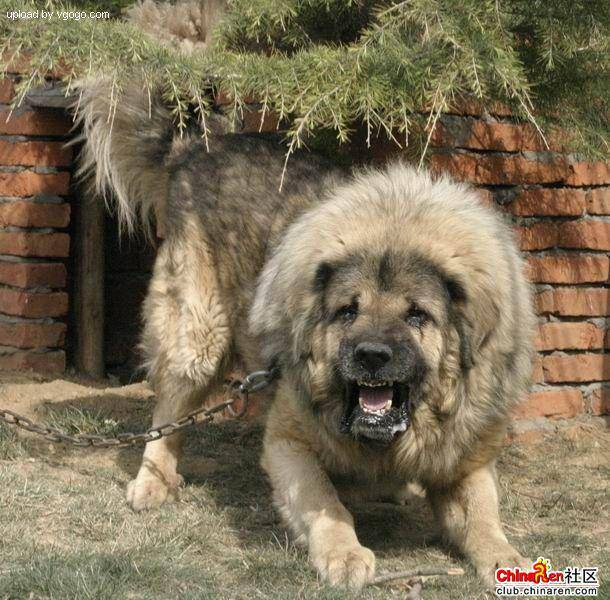

In [0]:
# One more check
Image(filenames[9000])

In [0]:
# Check for id and breed
print("ID : ", labels_csv["id"][9000])
print("Breed : ", labels_csv["breed"][9000])

ID :  e20e32bf114141e20a1af854ca4d0ecc
Breed :  tibetan_mastiff


## Converting Images to Numbers (Tensors/NumPyArrays)

In [0]:
labels = labels_csv["breed"].to_numpy()

# Another way to do so
# labels = np.array(labels)

labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [0]:
len(labels)

10222

In [0]:
# See if no of labels matches number of filenames
if len(labels)==len(filenames):
  print("No. of Labels = No.of Files")
else:
  print("No. of Labels != No.of Files")

No. of Labels = No.of Files


In [0]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [0]:
len(unique_breeds)

120

In [0]:
# Turn a single label to boolean
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [0]:
# Turn every label to boolean values
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
len(boolean_labels)

10222

In [0]:
# Example of converting boolean arrays into numbers
print(labels[0]) # Orignal Label
print(np.where(unique_breeds == labels[0])) # Index where labels occur
print(boolean_labels[0].argmax()) #Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be 1 where the sample label occurs


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Split the data into training and validation Sets

Since the datafrom kaggle don't have  as validation set we would create our own validation set.

In [0]:
# Set up X and y
X = filenames
y = boolean_labels




#### As 10000 images will take a lot of time we would use 1000 samples as first and increase as needed

In [0]:
# Setting up images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max:10000, step: 1000}

In [0]:
# Let's split the data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation sets of size  NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], 
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [0]:
# Let's view training data
X_train[:2], y_train[:2]

(['drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, 

# Preprocessing images (Converting into Tensors)

* Take Image file path as input.
* Use TensorFlow to read the file and save it to a variable `image`
* Turn our `image` (a jpg) into Tensors
* Normalize our image (Convert color channel values from 0-255 to 0-1)
* Resize the `image` to shape of (224, 224)
* Return the modified image

**Before doing so let's see how importing images look like**

In [0]:


from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [0]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [0]:
image.max(), image.min()

(255, 0)

In [0]:
# Converting images to tensors
img = tf.constant(image)
img

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [0]:
image.shape, img.shape

((257, 350, 3), TensorShape([257, 350, 3]))

#### Creating a function to convert images to tensors (ie merging the above 5 steps)


In [0]:
# Define image size
IMG_SIZE = 224

# Create a function to preprocess images
def preprocess_img(image_path):
  '''
  Takes a image file path and converts it to tensors
  '''
  # Read a image file
  image = tf.io.read_file(image_path)

  # Turn the jpg image to tensors with 3 colour channels (Reed, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the channel colour values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  
  return image

### Converting Data To Batches

Default Batch Size = 32 

Processing 10,000+  images in one go might not fit into memory.

So, that's why we do about 32 (batch size) images at a time, we can change the batch size manually.
 
**In order to use the TensorFlow model effectively, we need our data in the form of Tensor tuples which look like `(image, label)`** 

In [0]:
# Create a Function to return tensor tuples
def get_image_label(image_path, label):
  '''
  Takes the image path and associated label , processses the image and returns the tuple of (image, label)
  '''
  image = preprocess_img(image_path)
  return image, label

In [0]:
# Demo of the above function
(preprocess_img(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've converted our data into tupes of Tensors in the form `{image, label}`, now let's make a function converting the data and labels into batches of size 32

In [0]:
# define the Batch size
BATCH_SIZE = 32

# creating the function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image(X) and labels(y) pairs,
  Shuffles the data if it's training data, but doesn't shuffle if it has validation data.
  Also accepts est data as input (no Labels)
  """

  # If the data is the test dataset, we don't have labels
  if test_data:
    print("Creating Test Data Batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths no labels
    data_batch = data.map(preprocess_img).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is validation dataset we  don't need to shuffle it
  elif valid_data:
    print("Creating Validation Data Batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # Both Filepaths and labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)

  # If the data is training dataset
  else:
    print("Creating Training Data Batches") 
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # Both Filepaths and labels

    # shuffling the pathnames and labels into tensors (As shuffling the filenames is economical than shuffling images)
    data = data.shuffle(buffer_size=len(X))

    # create (image, labels) tuples
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [0]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating Training Data Batches
Creating Validation Data Batches


In [0]:
# Check out different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualising the data

Our data is in batches, It would be great if we could visualize it

In [0]:
import matplotlib.pyplot as plt

# Creating a function to visualize data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from the data batch.
  We're using only 25 images becoz plotting all the images would take a lot of time.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))

  # loop through 25(for 25 images)
  for i in range(25):
    
    # Create Subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)

    # Display an image
    plt.imshow(images[i])

    # Add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])

    # turn the grid lines off
    plt.axis("off")

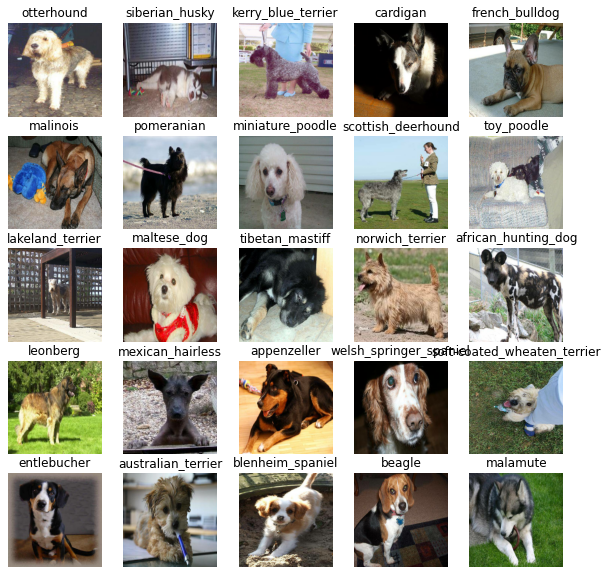

In [0]:
# unbatching data
train_images, train_labels = next(train_data.as_numpy_iterator())

# Visualising the data
show_25_images(train_images, train_labels)

In [0]:
# Checking the size of train_images and train_labels
print("Batch Size : ", BATCH_SIZE)
print("train_images Size : ", len(train_images))
print("train_labels Size : ", len(train_labels))

Batch Size :  32
train_images Size :  32
train_labels Size :  32


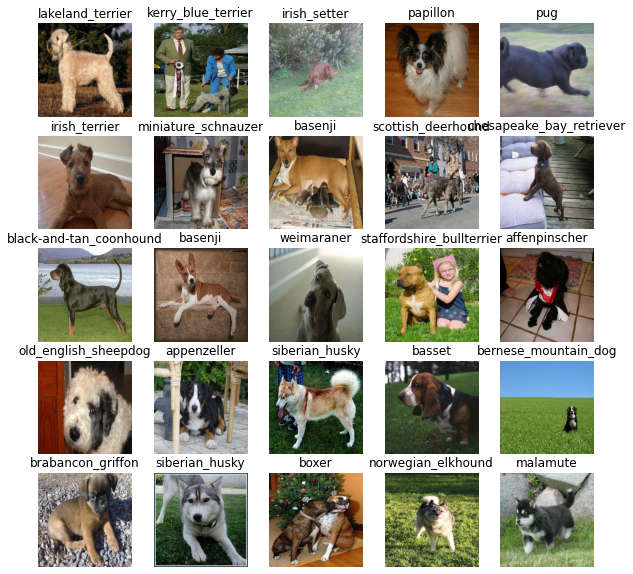

In [0]:
# Now let's visualize the validation set

# unbatching data
val_images, val_labels = next(train_data.as_numpy_iterator())

# Visualising the data
show_25_images(val_images, val_labels)

## Building the model

 Before we build the model, there are a few things we need to define:
 * The `input` shape (Our image shape, in form of Tensors) to our model.
 * The `output` shape (image labels, in form of Tensors) to our model.
 * The URL of model we want to use (https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4).

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour-channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Let's put the `INPUT_SHAPE`,`OUTPUT_SHAPE`, `MODEL_URL` together into a Keras Deep Learning Model

Let's create a function which:
* Takes the input shape, output shape, and model chosen as parameters.
* Defines the layers in Keras Model in sequential fashion (Linear step by step process).
* Compile the Model (how itshould be evaluated and improved.)
* Build the model (tells the model the i/p shape it will be getting).
* Returns the model

**All of the above steps can be foyund at https://www.tensorflow.org/guide/keras/overview

In [0]:

# Create a function which builds a Keras Model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  """
  Creates a Keras model
  """
  print("Building Models with : ", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL),                   # Layer 1 (Input Layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                                                     activation="softmax"), #Layer 2 (Output Layer)
                              ])

  # Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
              )

  # Build the model
  model.build(INPUT_SHAPE)

  return model 

In [0]:
model = create_model()
model.summary()

Building Models with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to do such things as save itws properties, check its progress or stop training early if model stops improving.
https://keras.io/callbacks/

We'll create 2 callbacks, one for TensorBoard which helps track our model progress and another for early stopping  which prevents our model from training for too long.

### TensorBoard Callback

To set up TensorBoard Callback, we need to do 3 things:-
1. Load TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to the model's `fit()` function.
3. Visualize our model's training logs with the `%tensorflow` magic function (we'll do after model training)

In [0]:
# load TensorBoard Notebook extension
%load_ext tensorboard

In [0]:
# Import datetime function to use the date and time to track the experiments
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():

  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Colab Notebooks/dog-identifier/logs",    # tracking the logs whenever we run the experiments.
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps to stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [0]:
# Creating a early stopping callbacks (used when evaluation metric stops imporoving)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training a Deep Learning Model (on a subset of data)

We're going to train 1000 model as first inorder to reduce our time in experimentation and make sure that everything is working.

In [0]:
# EPOCHS -> How many passes of data we want our model to do ?
#           A pass is equivalent to our model finding patterns in our dog image and see which pattern relate to our image.
NUM_EPOCHS = 100 # @param {type: "slider", min: 10, max: 100, step: 10} 

In [0]:
# Check to make sure we're still running on GPU
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else "not available")

GPU Available


Let's create a function which trains a model.

* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it to the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use.
* Return the model.

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # Create a model
  model = create_model()

  # Create a new TensorBoard session every time we train the model
  tensorboard = create_tensorboard_callback()

  # Fit the model to data passingit the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model
  return model

In [0]:
# Fit the model to data
model = train_model()

Building Models with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 252s 10s/step - loss: 4.5142 - accuracy: 0.0925 - val_loss: 3.3582 - val_accuracy: 0.2250
Epoch 2/100
25/25 [==============================] - 4s 178ms/step - loss: 1.6131 - accuracy: 0.6850 - val_loss: 2.0943 - val_accuracy: 0.4650
Epoch 3/100
25/25 [==============================] - 4s 177ms/step - loss: 0.5567 - accuracy: 0.9425 - val_loss: 1.6256 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 5s 183ms/step - loss: 0.2480 - accuracy: 0.9912 - val_loss: 1.4404 - val_accuracy: 0.5950
Epoch 5/100
25/25 [==============================] - 5s 193ms/step - loss: 0.1439 - accuracy: 0.9975 - val_loss: 1.3605 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 5s 189ms/step - loss: 0.1007 - accuracy: 1.0000 - val_loss: 1.3329 - val_accuracy: 0.6450
Epoch 7/100
25/25 [===========================

**NOTE :** Overfitting is good thing becoz it means our model is learning!!!

### Viewing the TensorBoard log records

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize the contents

In [0]:
%tensorboard --logdir drive/My\ Drive/Colab\ Notebooks/dog-identifier/logs/20200410-145527

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model


In [0]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 111ms/step


array([[6.5202202e-04, 1.2821656e-04, 3.8502330e-03, ..., 9.3074352e-04,
        2.5590785e-05, 8.1340391e-03],
       [4.4157738e-03, 1.5135193e-03, 7.0706993e-02, ..., 2.3810831e-03,
        4.1776360e-03, 1.5461139e-03],
       [2.0209237e-04, 7.8283862e-04, 1.0793606e-03, ..., 1.2828351e-04,
        2.7818020e-04, 2.0916888e-03],
       ...,
       [2.7191354e-05, 2.9252882e-05, 3.6730788e-05, ..., 8.1193048e-06,
        3.1959436e-05, 3.7605456e-05],
       [1.8167151e-03, 9.3288269e-05, 8.3914732e-05, ..., 2.5470732e-04,
        3.2337146e-05, 5.2778046e-03],
       [1.8235185e-04, 2.7546863e-04, 1.8642362e-02, ..., 2.4735932e-03,
        1.4634160e-03, 3.2043830e-05]], dtype=float32)

In [0]:
predictions.shape, len(y_val), len(unique_breeds)

((200, 120), 200, 120)

In [0]:
# First Predictions
index = 0
print(predictions[index])
print(f"Max Value (probability of prediction) : {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max Index : {np.argmax(predictions[index])}")
print(f"Predicted Label: {unique_breeds[np.argmax(predictions[index])]}")

[6.52022019e-04 1.28216561e-04 3.85023304e-03 2.61618006e-05
 4.64912649e-04 2.09828911e-04 7.78002013e-03 5.27910423e-04
 2.49332283e-04 1.42838515e-04 2.04169936e-03 4.41180564e-05
 7.11852161e-04 6.73344548e-05 1.15302845e-03 2.26717605e-03
 1.12291265e-04 2.88684785e-01 3.37629317e-05 1.26272818e-04
 1.64426674e-04 8.72037635e-05 2.70563123e-05 7.55543006e-04
 2.15102209e-05 2.81239074e-04 1.13534242e-01 1.56515125e-05
 1.56839291e-04 7.70096958e-04 1.44437523e-04 4.56183823e-03
 8.52020516e-04 2.52565369e-05 1.19998302e-04 1.13215975e-01
 6.39525970e-05 7.07852247e-04 3.80348094e-04 3.56254459e-04
 1.80991786e-03 3.52807801e-05 1.35648137e-04 2.56802567e-04
 3.66739660e-05 1.16223062e-04 2.64965347e-04 6.88542350e-05
 1.25972962e-04 5.58725500e-04 2.52184022e-04 5.33599996e-05
 1.63335775e-04 1.68868995e-04 7.23811798e-04 6.94855262e-05
 2.09606427e-04 9.59124824e-04 8.33201557e-05 9.36645493e-02
 2.22707764e-04 3.65871529e-05 1.95709406e-03 2.41301295e-05
 8.33660539e-04 6.230451

In [0]:
# Turn prediction probabilites into respective labels
def get_pred_labels(prediction_probabilites):
  """
  Turn an array of prediction probabilities into labels 
  """
  return unique_breeds[np.argmax(prediction_probabilites)]

# Get a predicted label based on an array  
pred_label = get_pred_labels(predictions[0])
pred_label

'border_terrier'

Now since our val_data is in batch format so we need to unbatch it to make predictions 

In [0]:
# create the function to unbatch a batch dataset
def unbatch(data):
  """
  Take a batched dataset of (image, label) Tensors and return seprate arrays of 
  images and labels.
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation sets
val_images, val_labels = unbatch(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

## Visualising the Predictions

Now we've got ways to get
* Prediction Labels
* Validation Labels
* Validation Images

Let's make them more visual

We will create a function with
* Take an array of prediction probabilities, an array of truth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted labels.
* Plot the predicted label, it's predicted probability, the truth label and the target image on a single plot.

In [0]:

def plot_preds(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get teh pred label
  pred_label = get_pred_labels(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong.
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change the plot title to be predicted , probability of prediction and truth labels
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

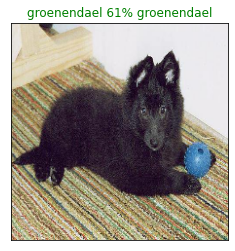

In [0]:
plot_preds(prediction_probabilities=predictions, 
           labels=val_labels, 
           images=val_images,
           n=77)

Now we've got one function to visualize our model's top prediction.
Now let us make a function to view our models top 10 predictions.

The function will need:
* Take an i/p of prediction probability array, ground truth array and a integer
* find the prediction using `get_pred_labels()`
* find the top 10:
  * Prediction Probabilities Indexes
  * Prediction Probabilities values
  * Prediction Labels
* Plot the top 10 predictions values and labels, coloring the true label green.

In [0]:











def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Predict the top 10 highest predictions with the truth label for sample n.  
  """
  pred_prob, truth_label = prediction_probabilities[n], labels[n]

  # Get the predicted labels
  pred_labels = get_pred_labels(pred_prob)

  # Find the top 10 prediction indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plots
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # change the color of true label
  if np.isin(truth_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels==truth_label)].set_color("green")
  else:
    pass


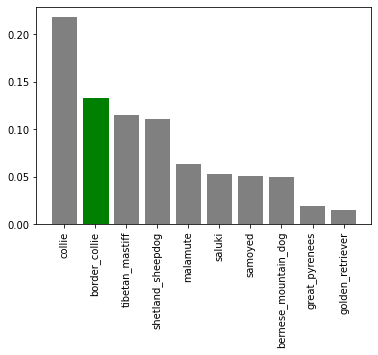

In [0]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

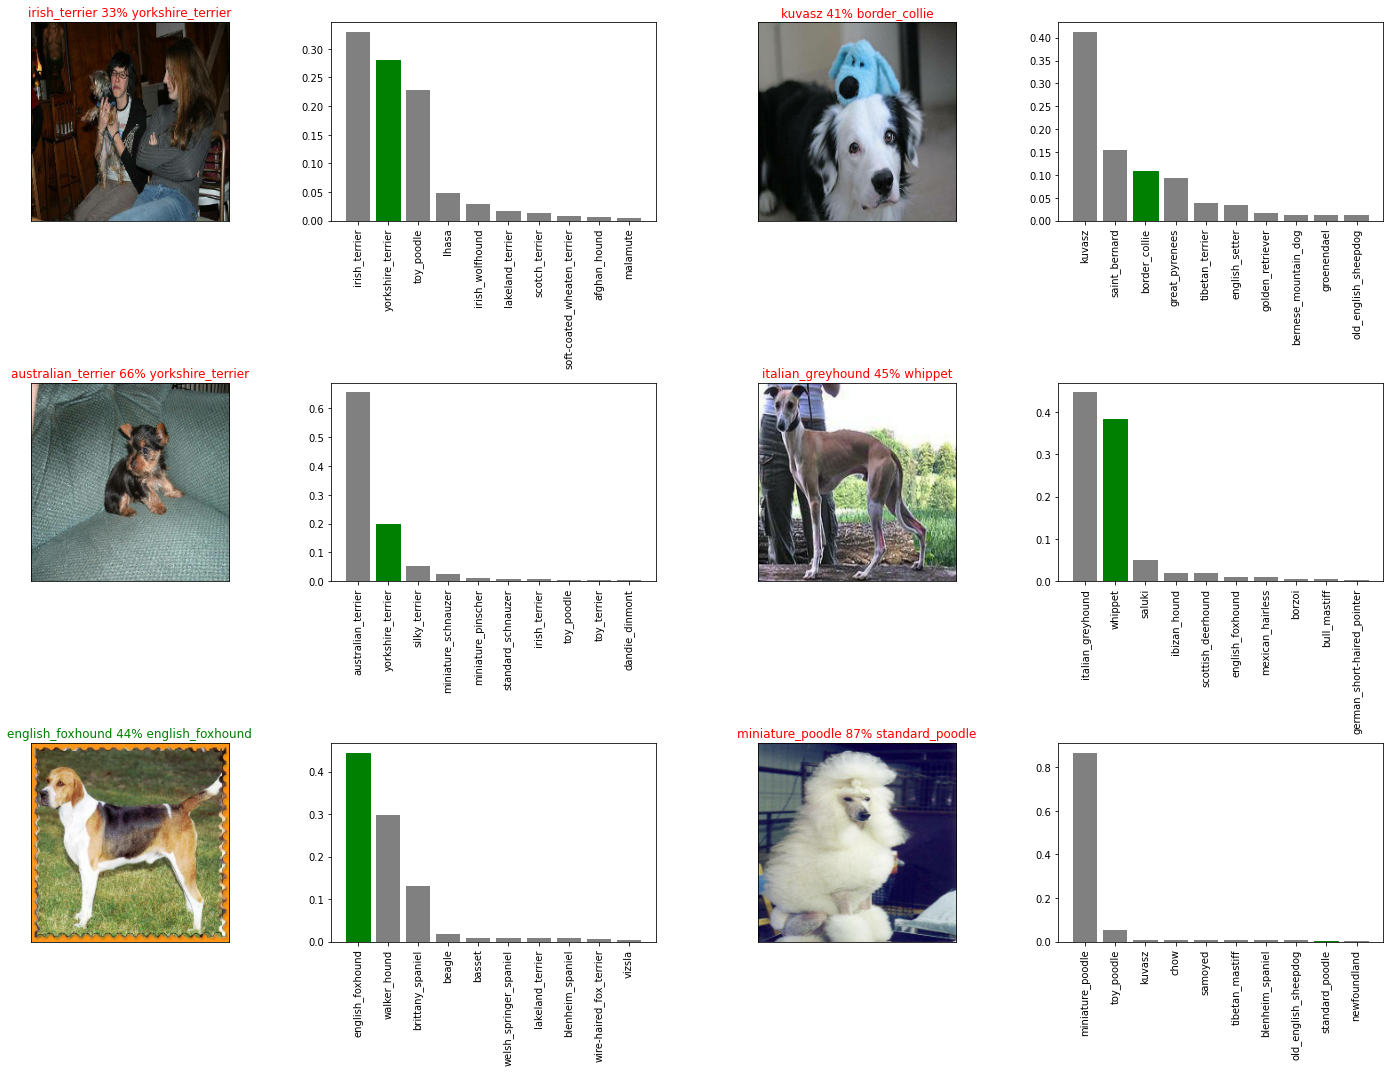

In [0]:
# Let's check out a few predictions and their different values
i_multiplier = 10 
num_rows = 3     
num_cols = 2     
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_preds(prediction_probabilities=predictions,
             labels=val_labels,
             images=val_images,
             n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## SAVING AND RELOADING A TRAINED MODEL

In [0]:
# Creating a function to save the model
def save_model(model, suffix=None):
    """
    saves the model in a models directory and appends a suffix    
    """

    # Create a model directory pathname and current time
    model_dir = os.path.join("drive/My Drive/Colab Notebooks/dog-identifier/models",
                             datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = model_dir + "-" + suffix +".h5" # save format extension of model
    print(f"Saving model to: {model_path}")
    model.save(model_path)
    return model_path

In [0]:
# Creating a function to reload the model
def load_model(model_path):
  """
  Loads a saved model from specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

**Now we've got functions to save and load our models let test it**

In [0]:
# Saving our model trained on 1000 images
save_model(model, suffix="1000-images-model-(mobilenetv2-Adam)")

Saving model to: drive/My Drive/Colab Notebooks/dog-identifier/models/20200413-09551586771706-1000-images-model-(mobilenetv2-Adam).h5


'drive/My Drive/Colab Notebooks/dog-identifier/models/20200413-09551586771706-1000-images-model-(mobilenetv2-Adam).h5'

In [0]:
# Loading the model
load_1000_image_model = load_model("drive/My Drive/Colab Notebooks/dog-identifier/models/20200411-02281586572083-1000-images-model-(mobilenetv2-Adam).h5")

Loading saved model from: drive/My Drive/Colab Notebooks/dog-identifier/models/20200411-02281586572083-1000-images-model-(mobilenetv2-Adam).h5


In [0]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 105ms/step - loss: 1.2612 - accuracy: 0.6450


[1.2612278461456299, 0.6449999809265137]

In [0]:
# Evaluate the loaded model
load_1000_image_model.evaluate(val_data) 

7/7 [==============================] - 1s 113ms/step - loss: 1.2550 - accuracy: 0.6400


[1.255020260810852, 0.6399999856948853]

## Training the model on **Full Dataset**

In [0]:
# Create a data batch  with full dataset
full_data_batch = create_data_batches(X, y)

Creating Training Data Batches


In [0]:
# Create a model for full dataset
full_model = create_model()

Building Models with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set for training on all the data, so without our early stopping callback we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3) # Stops if the accuracy doesn't change for 3 epochs


**Note :** Running the cell below will take a little while becoz the GPU we're using in run time has to load all of the images into memory.

In [0]:
# Fit the full model to full dataset
full_model.fit(x=full_data_batch,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 3949s 12s/step - loss: 1.3171 - accuracy: 0.6741
Epoch 2/100
320/320 [==============================] - 48s 152ms/step - loss: 0.3985 - accuracy: 0.8841
Epoch 3/100
320/320 [==============================] - 49s 152ms/step - loss: 0.2376 - accuracy: 0.9330
Epoch 4/100
320/320 [==============================] - 48s 151ms/step - loss: 0.1528 - accuracy: 0.9615
Epoch 5/100
320/320 [==============================] - 50s 155ms/step - loss: 0.1065 - accuracy: 0.9791
Epoch 6/100
320/320 [==============================] - 49s 153ms/step - loss: 0.0756 - accuracy: 0.9878
Epoch 7/100
320/320 [==============================] - 50s 155ms/step - loss: 0.0593 - accuracy: 0.9909
Epoch 8/100
320/320 [==============================] - 49s 154ms/step - loss: 0.0476 - accuracy: 0.9938
Epoch 9/100
320/320 [==============================] - 49s 154ms/step - loss: 0.0374 - accuracy: 0.9965
Epoch 10/100
320/320 [==============================] - 50s 156m

In [0]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Colab Notebooks/dog-identifier/models/20200413-09551586771720-full-image-set-mobilenetv2-Adam.h5


'drive/My Drive/Colab Notebooks/dog-identifier/models/20200413-09551586771720-full-image-set-mobilenetv2-Adam.h5'

In [0]:
# Load the full model
loaded_full_model = load_model('drive/My Drive/Colab Notebooks/dog-identifier/models/20200411-04491586580583-full-image-set-mobilenetv2-Adam.h5')


Loading saved model from: drive/My Drive/Colab Notebooks/dog-identifier/models/20200411-04491586580583-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in form of tensor batches, to make predictions on the data we'll have to get it into the same format.

We've `create_data_batches()` earlier which can take a list of filenames as input and convert them into tensor batches.

To make predictions on test data we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches` function and setting the `test_data` parameter `True` (Since test data don't have labels).
* Make predictions array by passing the test batches to the `predict()` method called on the model.

In [0]:
# Load test image filenames
test_path = "drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/e9f806911b69ca8fe705006ab7b49bdf.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/e8232c9a79f0e77e9b4c5fca60682d41.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/f195789502ac83352770c6718ba9eaa2.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/f18e43d6627bf395c2e3aae518067004.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/e8899ab63ea8630d50f0b321cb4bf811.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/f16eed64196d24c423f0a68d7ebf287d.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/ec429df7ceab9763e4e790b569997346.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/dog-breed-identification/p/test/ef4c9b0875ec51068b2720a01fa36b65.jpg',
 'drive/My Drive/Colab Notebooks/dog-identifier/

In [0]:
# Creating test data batch
test_data_batch = create_data_batches(test_filenames, test_data=True)

Creating Test Data Batches


**NOTE :** Calling `predict()` on our full model and passing it the test data batch take a long time.

In [0]:
# Make Predictions on test databatch using loaded full model
test_predictions = loaded_full_model.predict(test_data_batch, 
                                           verbose=1)

 33/324 [==>...........................] - ETA: 43:59

In [0]:
# Save Predictions (NumPy array) to csv file (for access later) (Helpful in case of runtime disconnection)
np.savetxt("drive/My Drive/Colab Notebooks/dog-identifier/preds_array.csv", test_predictions, delimiter=",")

In [0]:
# Load the prediction numpy arrays
test_prediction = np.loadtxt("drive/My Drive/Colab Notebooks/dog-identifier/preds_array.csv", delimiter=",")

In [0]:
test_prediction[:10]

array([[1.08415694e-08, 3.01049923e-08, 6.18070038e-03, ...,
        1.74006260e-07, 4.40329700e-07, 4.83962292e-09],
       [8.27897375e-13, 5.60682167e-07, 1.33246591e-11, ...,
        1.49975365e-10, 4.35586145e-09, 2.42066855e-09],
       [3.81252495e-12, 4.43665460e-09, 1.55468925e-07, ...,
        9.39938836e-05, 8.24833751e-06, 1.79882040e-10],
       ...,
       [8.89586738e-10, 1.59259308e-08, 8.37041374e-12, ...,
        1.78696684e-08, 2.52489713e-07, 2.92461016e-04],
       [3.60847775e-11, 2.04045794e-10, 1.52519664e-12, ...,
        1.98829245e-10, 9.63509166e-08, 4.27186932e-12],
       [1.10205700e-09, 2.75890795e-08, 2.96375396e-10, ...,
        2.79539165e-07, 3.41148308e-07, 6.85475765e-09]])

In [0]:
test_prediction.shape

(10357, 120)

## Preparing test data predictions

We'll create:
* Create a pandas DataFrame with an `ID` column as well as a column for each dog breed.
* Add data to the `ID` column by extracting the test image `ID's` from their file-paths.
* Add data (the prediction probabilities) to each of the dog-breed columns.
* Export the DataFrame as a CSV.


In [0]:
# Create a pandas DataFrame
pred_df = pd.DataFrame(columns=["id"]+list(unique_breeds))
pred_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Append image id's to prediction dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)] 
pred_df['id'] = test_ids

In [0]:
pred_df.head()

id  ... yorkshire_terrier
0  e9f806911b69ca8fe705006ab7b49bdf  ...               NaN
1  e8232c9a79f0e77e9b4c5fca60682d41  ...               NaN
2  f195789502ac83352770c6718ba9eaa2  ...               NaN
3  f18e43d6627bf395c2e3aae518067004  ...               NaN
4  e8899ab63ea8630d50f0b321cb4bf811  ...               NaN

[5 rows x 121 columns]

In [0]:
# Add the predictions probabilities  to each dog breed column
pred_df[list(unique_breeds)] = test_prediction
pred_df.head()

id  ... yorkshire_terrier
0  e9f806911b69ca8fe705006ab7b49bdf  ...       4.83962e-09
1  e8232c9a79f0e77e9b4c5fca60682d41  ...       2.42067e-09
2  f195789502ac83352770c6718ba9eaa2  ...       1.79882e-10
3  f18e43d6627bf395c2e3aae518067004  ...       8.31986e-09
4  e8899ab63ea8630d50f0b321cb4bf811  ...        3.3275e-08

[5 rows x 121 columns]

In [0]:
# Export dataframe as CSV
pred_df.to_csv("drive/My Drive/Colab Notebooks/dog-identifier/full-model-prediction-(mobilenetv2-Adam).csv", index=False)

In [0]:
pred = pd.read_csv("drive/My Drive/Colab Notebooks/dog-identifier/full-model-prediction-(mobilenetv2-Adam).csv")
pred.head()

id  ...  yorkshire_terrier
0  e9f806911b69ca8fe705006ab7b49bdf  ...       4.839623e-09
1  e8232c9a79f0e77e9b4c5fca60682d41  ...       2.420669e-09
2  f195789502ac83352770c6718ba9eaa2  ...       1.798820e-10
3  f18e43d6627bf395c2e3aae518067004  ...       8.319859e-09
4  e8899ab63ea8630d50f0b321cb4bf811  ...       3.327504e-08

[5 rows x 121 columns]